# Ground-truth comparison and ensemble sorting of a synthetic Neuropixels recording

This notebook reproduces figures 2 and 3 from the paper [**SpikeInterface, a unified framework for spike sorting**](https://www.biorxiv.org/content/10.1101/796599v2).

The data set for this notebook is available on the Dandi Archive: [https://gui.dandiarchive.org/#/dandiset/000034](https://gui.dandiarchive.org/#/dandiset/000034).

The entire data archive can be downloaded with the command `dandi download https://gui.dandiarchive.org/#/dandiset/000034/draft` (about 75GB).

The data file required to run the code is:
- the raw data: [sub-MEAREC-250neuron-Neuropixels_ecephys.nwb](https://girder.dandiarchive.org/api/v1/item/5f2c0e33ee8baa608594a16b/download)

This file should be in the same directory where the notebook is located (otherwise adjust paths below).

Author: [Matthias Hennig](http://homepages.inf.ed.ac.uk/mhennig/), University of Edinburgh, 22 Aug 2020

### Requirements

For this need you will need the following Python packages:

- numpy
- pandas
- matplotlib
- seaborn
- spikeinterface
- dandi
- matplotlib-venn

To run the MATLAB-based sorters, you would also need a MATLAB license.
For other sorters, please refer to the documentation on [how to install sorters](https://spikeinterface.readthedocs.io/en/latest/sortersinfo.html).

In [1]:
import os

# Matlab sorter paths:
# change these to match your environment
os.environ["IRONCLUST_PATH"] = "./ironclust"
os.environ["KILOSORT2_PATH"] = "./Kilosort2"
os.environ["HDSORT_PATH"] = "./HDsort"

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
import seaborn as sns
from collections import defaultdict
from matplotlib_venn import venn3

import spikeinterface as si
import spikeextractors as se
import spiketoolkit as st
import spikesorters as ss
import spikecomparison as sc
import spikewidgets as sw
from spikecomparison import GroundTruthStudy

%matplotlib inline

def clear_axes(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
# print version information
si.print_spikeinterface_version()
ss.print_sorter_versions()

spikeinterface: 0.9.9
  * spikeextractor: 0.8.4
  * spiketoolkit: 0.6.3
  * spikesorters: 0.3.3
  * spikecomparison: 0.2.6
  * spikewidgets: 0.4.3

hdsort: version = '1.0.2'

herdingspikes: 0.3.7
ironclust: 5.9.8
kilosort2: git-48bf2b81d8ad
klusta: 3.0.16
mountainsort4: unknown
spykingcircus: 0.9.7
tridesclous: 1.6.0


# Set up ground truth study an run all sorters

In [2]:
study_path = Path('.')
data_path = Path('.')
study_folder = study_path / 'study_mearec_250cells_Neuropixels-384chans_duration600s_noise10uV_2020-02-28/'

# the original data
# this NWB file contains both the ground truth spikes and the raw data
data_filename = data_path / 'sub-MEAREC-250neuron-Neuropixels_ecephys.nwb'
SX_gt = se.NwbSortingExtractor(str(data_filename))
RX = se.NwbRecordingExtractor(str(data_filename))

if not os.path.isdir(study_folder):
    gt_dict = {'rec0' : (RX, SX_gt) }
    study = GroundTruthStudy.create(study_folder, gt_dict)
else:
    study = GroundTruthStudy(study_folder)

sorter_list = ['herdingspikes', 'kilosort2', 'ironclust',
               'spykingcircus', 'tridesclous', 'hdsort']
sorter_names = ['HerdingSpikes', 'Kilosort2', 'Ironclust',
               'SpykingCircus', 'Tridesclous', 'HDSort']
sorter_names_short = ['HS', 'KS', 'IC', 'SC', 'TDC', 'HDS']

study.run_sorters(sorter_list, mode='keep', engine='loop', verbose=True)

study.copy_sortings()

# compute or load SNR for the ground truth units
snr_file = study_folder / 'snr.npy'
if os.path.isfile(snr_file):
    snr = np.load(snr_file)
else:
    print('computing snr')
    # note this is quite slow for a NWB file as the data is arranged as channels:time
    # it is faster to first write out a binary file in time:channels order
    snr = st.validation.compute_snrs(SX_gt, RX, apply_filter=False, verbose=False, 
                                     memmap=True, max_spikes_per_unit_for_snr=500)
    np.save(snr_file, snr)

/disk/scratch/mhennig/miniconda3/envs/spikesorting/lib/python3.7/site-packages/spikeextractors/extractors/matsortingextractor/matsortingextractor.py:65: ResourceWarning: unclosed file <_io.BufferedReader name='/disk/scratch/mhennig/spikeinterface/paper/MEArec/study_mearec_250cells_Neuropixels-384chans_duration600s_noise10uV_2020-02-28/sorter_folders/rec0/hdsort/hdsort_output/hdsort_output_results.mat'>
  raise ImportError("Version 7.2 .mat file given, but you don't have h5py installed.")


# Run the ground truth comparison and summarise the results

In [3]:
study.run_comparisons(exhaustive_gt=True, match_score=0.1)
comparisons = study.comparisons
dataframes = study.aggregate_dataframes()

In [4]:
# comparison summary
dataframes['count_units']

rec_name    sorter_name  num_gt  num_sorter  num_well_detected  \
0     rec0      ironclust     250         283                202   
1     rec0  spykingcircus     250         343                175   
2     rec0    tridesclous     250         189                135   
3     rec0         hdsort     250         457                196   
4     rec0      kilosort2     250         415                245   
5     rec0  herdingspikes     250         233                128   

   num_redundant  num_overmerged  num_false_positive  num_bad  
0              8               2                  41       49  
1             43               1                  56       99  
2              3               5                   9       12  
3              4               3                 210      214  
4             21               2                 147      168  
5              6               3                  39       45

# Figure 1 - ground truth study results

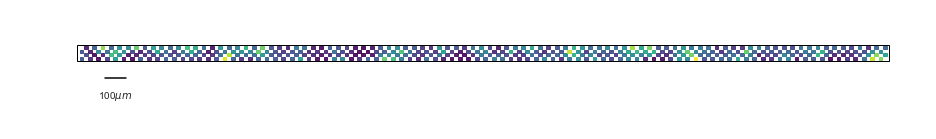

In [5]:
# activity levels on the probe

plt.figure(figsize=(16,2))
ax = plt.subplot(111)
w = sw.plot_activity_map(RX, trange=(0,20), transpose=True, ax=ax, background='w', frame=True)
ax.plot((-1800,-1700), (-120,-120), 'k-')
ax.annotate('100$\\mu m$',(-1750,-220), ha='center');


(-750, 4435.259765625)

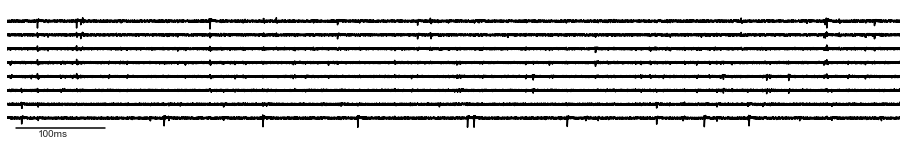

In [6]:
# example data traces

plt.figure(figsize=(16,6))
ax = plt.subplot(111)
w = sw.plot_timeseries(RX, channel_ids=range(10,18), color='k', ax=ax, trange=(1,2))
ax.axis('off')
p = ax.get_position()
p.y0 = 0.58
ax.set_position(p)
ax.set_xticks(())
ax.plot((1.01,1.11),(-400,-400),'k-')
ax.annotate('100ms',(1.051,-750), ha='center');
ax.set_ylim((-750,ax.set_ylim()[1]))

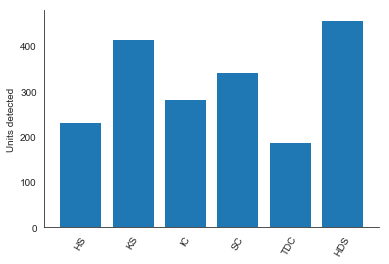

In [7]:
ax = plt.subplot(111)
n = []
for s in sorter_list:
    n.append(len(study.get_sorting(s).get_unit_ids()))
ax.bar(range(len(sorter_list)), n, color='tab:blue')
ax.set_xticks(range(len(sorter_names_short)))
ax.set_xticklabels(sorter_names_short, rotation=60, ha='center')
ax.set_ylabel('Units detected') 
clear_axes(ax)

/disk/scratch/mhennig/miniconda3/envs/spikesorting/lib/python3.7/site-packages/matplotlib/axes/_axes.py:4204: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  (isinstance(c, collections.Iterable) and


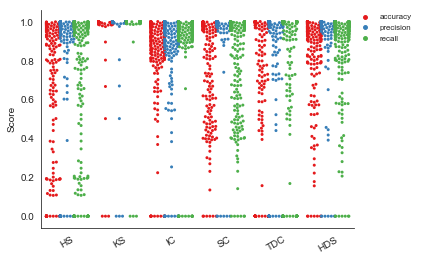

In [8]:
ax = plt.subplot(111)
p = ax.get_position()
p.x1=0.85
ax.set_position(p)
sns.set_palette(sns.color_palette("Set1"))
df = pd.melt(dataframes['perf_by_units'], id_vars='sorter_name', var_name='Metric', value_name='Score', 
        value_vars=('accuracy','precision', 'recall'))
sns.swarmplot(data=df, x='sorter_name', y='Score', hue='Metric', dodge=True,
                order=sorter_list,  s=3, ax=ax)
ax.set_xticklabels(sorter_names_short, rotation=30, ha='center')
ax.legend(bbox_to_anchor=(1.0, 1), loc=2, borderaxespad=0., frameon=False, fontsize=8, markerscale=0.5)
ax.set_xlabel(None);
ax.set_ylabel('Score');
clear_axes(ax)

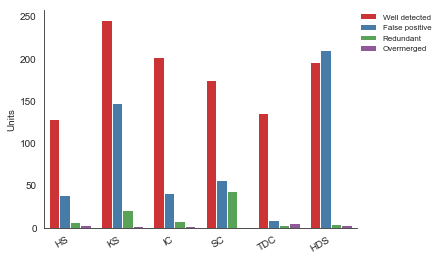

In [9]:
ax = plt.subplot(111)
p = ax.get_position()
p.x1=0.85
ax.set_position(p)
df = pd.melt(dataframes['count_units'], id_vars='sorter_name', var_name='Type', value_name='Units', 
        value_vars=('num_well_detected', 'num_false_positive', 'num_redundant', 'num_overmerged'))
sns.set_palette(sns.color_palette("Set1"))
sns.barplot(x='sorter_name', y='Units', hue='Type', data=df,
                order=sorter_list, ax=ax)
ax.set_xticklabels(sorter_names_short, rotation=30, ha='right')
ax.legend(bbox_to_anchor=(1.0, 1), loc=2, borderaxespad=0., frameon=False, fontsize=8, markerscale=0.1)
for t, l in zip(ax.legend_.texts, ("Well detected", "False positive", "Redundant", "Overmerged")): t.set_text(l)
ax.set_xlabel(None);
clear_axes(ax)

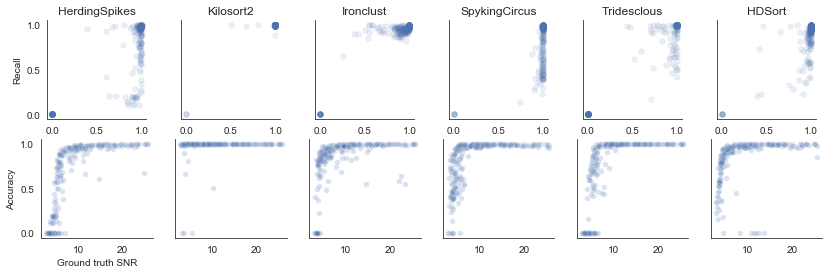

In [10]:
# precision vs. recall and accuracy vs. SNR
fig = plt.figure(figsize=(14, 4))

sns.set_palette(sns.color_palette("deep"))

axesA = []
for i,s in enumerate(sorter_list):
    ax = plt.subplot(2,len(sorter_list),i+1)
    axesA.append(ax)

    g = sns.scatterplot(data=dataframes['perf_by_units'].loc[dataframes['perf_by_units'].sorter_name==s], 
                    x='precision', y='recall', s=30, edgecolor=None, alpha=0.1)
    ax.set_title(sorter_names[i])
    ax.set_aspect('equal')
    clear_axes(ax)
    ax.set_xlabel('Precision')
    ax.set_ylabel('Recall')

for ax in axesA[1:]:
    axesA[0].get_shared_y_axes().join(axesA[0], ax)
    ax.set_yticklabels([])
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.autoscale()
    
############### B

df = dataframes['perf_by_units']

# add snr to the by-unit table
if 'snr' not in df.keys():
    snr_d = {k:snr[k] for i,k in enumerate(SX_gt.get_unit_ids())}
    df['snr'] = df['gt_unit_id'].map(snr_d)
    

axesB = []
for i,s in enumerate(sorter_list):
    ax = plt.subplot(2,len(sorter_list),len(sorter_list)+i+1)
    axesB.append(ax)
    
    g = sns.scatterplot(data=dataframes['perf_by_units'].loc[dataframes['perf_by_units'].sorter_name==s], 
                        x='snr', y='accuracy', s=30, alpha=0.2)
    clear_axes(ax)
    ax.set_xlabel('Ground truth SNR')
    ax.set_ylabel('Accuracy')
    
for ax in axesB[1:]:
    axesB[0].get_shared_y_axes().join(axesB[0], ax)
    ax.set_yticklabels([])
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.autoscale()
    

# Figure 3 - comparison of sorter outputs and ensembe sorting

In [11]:
# perform an all-to-all multicomparison or load it from
# disk if file exists

sortings = []
for s in sorter_list:
    sortings.append(study.get_sorting(s))

cmp_folder = study_folder / 'multicomparison/'
if not os.path.isdir(cmp_folder):
    os.mkdir(cmp_folder)
if not os.path.isfile(cmp_folder / 'multicomparison.gpickle'):
    mcmp = sc.compare_multiple_sorters(sorting_list=sortings, name_list=sorter_names_short, 
                                   verbose=False, match_score=0.5)
    print('saving multicomparison')
    mcmp.dump(cmp_folder)
else:
    print('loading multicomparison')
    mcmp = sc.MultiSortingComparison.load_multicomparison(cmp_folder)
    
mcmp_graph = mcmp.graph.copy()


loading multicomparison


In [12]:
# get sorting extractors with unit with no agreement (minimum agreement = 1) and one
# with at least 2 sorters in agreement
not_in_agreement = mcmp.get_agreement_sorting(minimum_agreement_count=1, minimum_agreement_count_only=True)
in_agreement = mcmp.get_agreement_sorting(minimum_agreement_count=2)

# score these against ground truth
cmp_no_agr = sc.compare_sorter_to_ground_truth(SX_gt, not_in_agreement)
cmp_agr = sc.compare_sorter_to_ground_truth(SX_gt, in_agreement)

# now collect results for each sorter:

# create dict to collect results
results = {'TP':{}, 'FP':{}, 'SNR':{}}
ns = len(sorter_names_short)
for s in sorter_names_short:
    results['TP'][s] = dict(zip(range(1,ns+1), [0]*(ns+1)))
    results['FP'][s] = dict(zip(range(1,ns+1), [0]*(ns+1)))
    results['SNR'][s] = dict(zip(range(1,ns+1), [[]]*(ns+1)))
    
# sorter names
dict_names = dict(zip(sorter_names_short, sorter_list))

# iterate over all units gathered from subgraphs
for u in  mcmp._new_units.keys():
    found_in_gt = []
    gt_index = []
    # check if units have a match in ground truth, store boolen
    for u2 in mcmp._new_units[u]['sorter_unit_ids'].items():
        found_in_gt.append(u2[1] in study.comparisons['rec0',dict_names[u2[0]]].best_match_12.values)
        if found_in_gt[-1]:
            gt_index.append(np.where(study.comparisons['rec0',dict_names[u2[0]]].best_match_12==u2[1])[0][0])
    if len(set(gt_index))>1:
        print('different gt units: ',u, gt_index)
    if np.sum(found_in_gt)==len(found_in_gt):
#     if np.sum(found_in_gt)>0:#==len(found_in_gt):  # use this if interested in equal matches
        key = 'TP'
    else:
        key = 'FP'
        if len(found_in_gt)>1:
            print('FP unit found by >1 sorter: ',u)
        
    for i,u2 in enumerate(mcmp._new_units[u]['sorter_unit_ids'].items()):
#         results[key][u2[0]][np.sum(found_in_gt)] += 1 # use this if interested in equal matches
        results[key][u2[0]][len(found_in_gt)] += 1
        if key is 'TP':
            # something odd with nested oython dicts requires this:
            d = results['SNR'][u2[0]][len(found_in_gt)].copy()
            d.append(snr[gt_index[i]])
            results['SNR'][u2[0]][len(found_in_gt)] = d
            # this fails, I wonder why:
            # results['SNR'][u2[0]][len(found_in_gt)].append(snr[gt_index[i]])


different gt units:  20 [213, 213, 213, 146, 213, 213]
different gt units:  35 [189, 189, 185, 189, 189]
different gt units:  42 [224, 224, 224, 76, 224, 224]
different gt units:  46 [108, 108, 108, 90, 108, 108]
FP unit found by >1 sorter:  92
different gt units:  102 [153, 197, 197, 197, 197, 197]
different gt units:  103 [175, 175, 175, 11, 175, 175]
FP unit found by >1 sorter:  111
different gt units:  114 [157, 157, 107, 157, 157, 157]
different gt units:  149 [78, 99, 99, 99, 99]
FP unit found by >1 sorter:  150
FP unit found by >1 sorter:  158
different gt units:  162 [179, 196, 196, 196, 196, 196]
different gt units:  284 [185, 185, 185, 177, 185]
different gt units:  316 [90, 90, 90, 57, 90]
FP unit found by >1 sorter:  418
FP unit found by >1 sorter:  549
different gt units:  673 [129, 182]


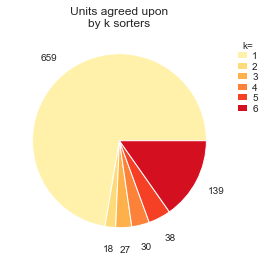

In [13]:
w = sw.plot_multicomp_agreement(mcmp, plot_type='pie')


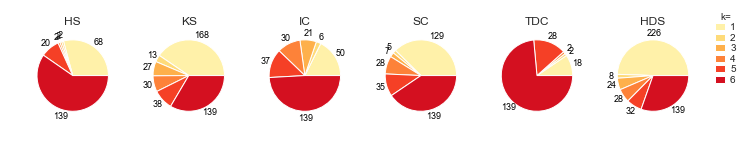

In [14]:
w = sw.plot_multicomp_agreement_by_sorter(mcmp, show_legend=True)


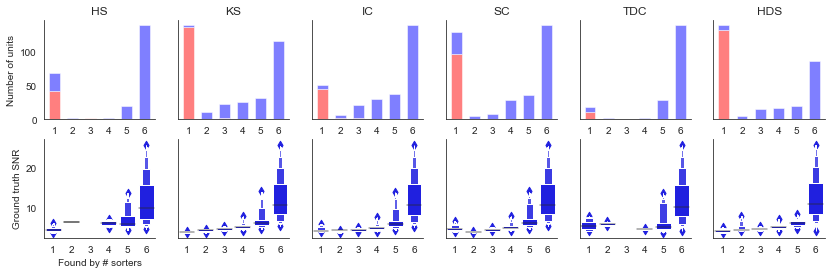

In [15]:
fig = plt.figure(figsize=(14,4))

axes = []
for i,s in enumerate(results['TP'].keys()):
    ax = plt.subplot(2,len(sorter_list), i+1)
    ax.bar(results['FP'][s].keys(), list(results['FP'][s].values()), alpha=0.5, width = 0.6, color='r', label='false positive')
    ax.bar(results['TP'][s].keys(), list(results['TP'][s].values()), bottom=list(results['FP'][s].values()), alpha=0.5, width = 0.6, color='b', label='matched')
    ax.set_xticks(range(1,len(sorter_list)+1))
    ax.set_xticklabels(range(1,len(sorter_list)+1))
    ax.set_title(s)
    clear_axes(ax)
    axes.append(ax)
    if i == 0:
        ax.set_ylabel('Number of units')
    else:
        ax.get_shared_y_axes().join(axes[0], ax)
        ax.set_yticklabels([])
    
    ax = plt.subplot(2,len(sorter_list), len(sorter_list)+i+1)
    d  = results['SNR'][s]
    sns.boxenplot(data=pd.DataFrame([pd.Series(d[k]) for k in d.keys()]).T, color='b', ax=ax)
    ax.set_xticks(range(0,len(sorter_list)))
    ax.set_xticklabels(range(1,len(sorter_list)+1))
    clear_axes(ax)
    axes.append(ax)
    if i == 0:
        ax.set_ylabel('Ground truth SNR')
        ax.set_xlabel('Found by # sorters')
    else:
        ax.get_shared_y_axes().join(axes[1], ax)
        ax.set_yticklabels([])
    

In [16]:
# numbers for figure above

sg_names, sg_units = mcmp.compute_subgraphs()
v, c = np.unique([len(np.unique(s)) for s in sg_names], return_counts=True)
df = pd.DataFrame(np.vstack((v,c,np.round(100*c/np.sum(c),2))).T,
             columns=('in # sorters','# units','percentage'))
print('all sorters, all units:')
print(df)
df = pd.DataFrame()
for i, name in enumerate(sorter_names_short):
    v, c = np.unique([len(np.unique(sn)) for sn in sg_names if name in sn], return_counts=True)
    cl = np.zeros(len(sorter_list), dtype=int)
    cl[v.astype(int)-1] = c
    df.insert(2*i,name,cl)
    df.insert(2*i+1,name+'%',np.round(100*cl/np.sum(cl),1))
print('\nper sorter:')
print(df)

for i,s in enumerate(results['TP'].keys()):
    print(s, list(results['FP'][s].values()))

all sorters, all units:
   in # sorters  # units  percentage
0           1.0    659.0       72.34
1           2.0     18.0        1.98
2           3.0     27.0        2.96
3           4.0     30.0        3.29
4           5.0     38.0        4.17
5           6.0    139.0       15.26

per sorter:
    HS   HS%   KS   KS%   IC   IC%   SC   SC%  TDC  TDC%  HDS  HDS%
0   68  29.2  168  40.5   50  17.7  129  37.6   18   9.5  226  49.5
1    2   0.9   13   3.1    6   2.1    5   1.5    2   1.1    8   1.8
2    2   0.9   27   6.5   21   7.4    7   2.0    0   0.0   24   5.3
3    2   0.9   30   7.2   30  10.6   28   8.2    2   1.1   28   6.1
4   20   8.6   38   9.2   37  13.1   35  10.2   28  14.8   32   7.0
5  139  59.7  139  33.5  139  49.1  139  40.5  139  73.5  139  30.4
HS [42, 1, 2, 0, 1, 0]
KS [164, 1, 2, 0, 1, 0]
IC [45, 2, 2, 0, 0, 0]
SC [97, 1, 0, 0, 1, 0]
TDC [11, 0, 0, 0, 1, 0]
HDS [214, 1, 0, 0, 1, 0]
